# PRACTICA 2

## 0. Importacion de Modulos

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import re
import unicodedata
from difflib import SequenceMatcher


spanish_stop_words = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /home/eduardo-
[nltk_data]     castillo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
def txt_to_list(filename):
    lines_list = []
    with open(filename, 'r') as file:
        for line in file:
            lines_list.append(line.strip()) # .strip() removes leading/trailing whitespace and newlines
    return lines_list



## 1. Data Wrangling


Los datos se obtuvieron de un chat de WhatsApp, posteriormente se exportaron a un TXT.

In [4]:
import re
import pandas as pd
from datetime import datetime

RUTA_ARCHIVO = "datos/Datos.txt"

PATRON_MENSAJE = re.compile(
    r'^(\d{1,2}/\d{1,2}/\d{4}), (\d{1,2}:\d{2})\s?(a\.?\s?m\.?|p\.?\s?m\.?) - (.*?): (.*)'
)


with open(RUTA_ARCHIVO, encoding="utf-8") as f:
    lineas = f.readlines()

mensajes = []
mensaje_actual = None

for linea in lineas:
    linea = linea.strip()

    match = PATRON_MENSAJE.match(linea)

    if match:
        # Guardar mensaje anterior
        if mensaje_actual:
            mensajes.append(mensaje_actual)

        fecha, hora, am_pm, autor, texto = match.groups()

        mensaje_actual = {
            "Fecha": fecha,
            "Hora": hora,
            "AM_PM": am_pm.lower(),
            "Autor": autor,
            "Mensaje": texto
        }
    else:
        # Línea adicional (mensaje multilínea)
        if mensaje_actual:
            mensaje_actual["Mensaje"] += " " + linea

# Agregar último mensaje
if mensaje_actual:
    mensajes.append(mensaje_actual)

# =========================
# 4. CREACIÓN DEL DATAFRAME
# =========================

df_original = pd.DataFrame(mensajes)

# =========================
# 5. LIMPIEZA BÁSICA
# =========================

# Eliminar mensajes del sistema
df_original = df_original[~df_original["Autor"].str.contains("mensajes y las llamadas|creó el grupo|te añadió", case=False, na=False)]

# Detectar multimedia
df_original["Tiene_Multimedia"] = df_original["Mensaje"].str.contains("Multimedia omitido|archivo adjunto", case=False).astype(int)

# Limpiar texto multimedia
df_original["Mensaje"] = df_original["Mensaje"].replace(
    to_replace=r"<Multimedia omitido>|archivo adjunto",
    value="",
    regex=True
)

# =========================
# 6. CONVERSIÓN DE FECHA Y HORA
# =========================

def convertir_hora(hora, am_pm):
    hora_dt = datetime.strptime(hora, "%H:%M")
    h = hora_dt.hour

    if am_pm.startswith("p") and h != 12:
        h += 12
    if am_pm.startswith("a") and h == 12:
        h = 0

    return h + hora_dt.minute / 60


df_original["Fecha"] = pd.to_datetime(df_original["Fecha"], format="%d/%m/%Y", errors="coerce")
df_original["Hora_Num"] = df_original.apply(lambda x: convertir_hora(x["Hora"], x["AM_PM"]), axis=1)

# =========================
# 7. FEATURES BÁSICAS DE TEXTO
# =========================

df_original["Num_Caracteres"] = df_original["Mensaje"].str.len()
df_original["Num_Palabras"] = df_original["Mensaje"].str.split().str.len()
df_original["Signo_Pregunta"] = df_original["Mensaje"].str.contains(r"\?", regex=True).astype(int)

# =========================
# 8. RESULTADO FINAL
# =========================

df_original = df_original.reset_index(drop=True)

print(df_original.head())
print("\nTotal de mensajes procesados:", len(df_original))

df_original.to_csv("datos_limpios.csv")

       Fecha  Hora  AM_PM             Autor  \
0 2024-04-26  9:21  p. m.  +52 244 785 9240   
1 2024-04-26  9:22  p. m.  +52 228 376 8878   
2 2024-04-26  9:23  p. m.  +52 244 785 9240   
3 2024-04-26  9:23  p. m.  +52 33 2648 4607   
4 2024-04-26  9:23  p. m.  +52 33 2648 4607   

                              Mensaje  Tiene_Multimedia   Hora_Num  \
0  Haber gente presuman sus plantitas                 0  21.350000   
1            Buenas noches gente 🧙‍♂️                 1  21.366667   
2                Nmms está bien chula                 0  21.383333   
3                                                     1  21.383333   
4                                                     1  21.383333   

   Num_Caracteres  Num_Palabras  Signo_Pregunta  
0              34             5               0  
1              25             4               0  
2              20             4               0  
3               0             0               0  
4               0             0               

In [5]:
df_original.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102133 entries, 0 to 102132
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Fecha             102133 non-null  datetime64[ns]
 1   Hora              102133 non-null  object        
 2   AM_PM             102133 non-null  object        
 3   Autor             102133 non-null  object        
 4   Mensaje           102133 non-null  object        
 5   Tiene_Multimedia  102133 non-null  int64         
 6   Hora_Num          102133 non-null  float64       
 7   Num_Caracteres    102133 non-null  int64         
 8   Num_Palabras      102133 non-null  int64         
 9   Signo_Pregunta    102133 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 7.8+ MB


In [6]:
PATRON_EMOJIS = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticonos
    "\U0001F300-\U0001F5FF"  # símbolos y pictogramas
    "\U0001F680-\U0001F6FF"  # transporte y mapas
    "\U0001F700-\U0001F77F"
    "\U0001F780-\U0001F7FF"
    "\U0001F800-\U0001F8FF"
    "\U0001F900-\U0001F9FF"
    "\U0001FA00-\U0001FAFF"
    "\u2600-\u26FF"          # símbolos varios
    "\u2700-\u27BF"
    "]+",
    flags=re.UNICODE
)


In [7]:
df_original["Mensaje"] = df_original["Mensaje"].str.replace(
    PATRON_EMOJIS,
    "",
    regex=True
)

In [8]:
df = df_original.copy()

In [9]:
import numpy as np

# 1. Convertir posibles valores nulos o vacíos en la columna Mensaje
# Esto limpia espacios en blanco y convierte celdas vacías en NaN
df['Mensaje'] = df['Mensaje'].astype(str).str.strip()
df['Mensaje'] = df['Mensaje'].replace(['', 'nan', 'None'], np.nan)

# 2. Eliminar las filas donde el Mensaje es nulo
# Usamos inplace=True para que los cambios se guarden en el mismo DataFrame
df.dropna(subset=['Mensaje'], inplace=True)

# 3. Opcional: Filtrar filas donde Num_Palabras sea 0
# (Como se ve en tus índices 3 y 4 de la imagen)
df = df[df['Num_Palabras'] > 0]

# Verificamos cuántas filas quedaron
print(f"Registros después de la limpieza: {len(df)}")
df.head()

Registros después de la limpieza: 100991


,Fecha,Hora,AM_PM,Autor,Mensaje,Tiene_Multimedia,Hora_Num,Num_Caracteres,Num_Palabras,Signo_Pregunta
0,2024-04-26,9:21,p. m.,+52 244 785 9240,Haber gente presuman sus plantitas,0,21.350000,34,5,0
1,2024-04-26,9:22,p. m.,+52 228 376 8878,Buenas noches gente ‍️,1,21.366667,25,4,0
2,2024-04-26,9:23,p. m.,+52 244 785 9240,Nmms está bien chula,0,21.383333,20,4,0
5,2024-04-26,9:24,p. m.,+52 244 785 9240,Yo nada más está haber si agarra color como cu...,1,21.400000,61,12,0
6,2024-04-26,9:24,p. m.,+52 33 2648 4607,‎STK-20240414-WA0145.webp (),1,21.400000,28,2,0


In [10]:
df["Mensaje"].str.extract(r"\.([^.]+)$")[0].unique() ##??????


array([nan, 'webp ()', '>', ..., 'com/share/r/14R9j91XkvY/', 'jpg () Xd',
       'com/ZSaJ36cFa/'], shape=(2919,), dtype=object)

## 2. Solucion Analıtica

### 2.1 Variable objetivo discreta

Esta variable se utiliza para identificar de manera clara el tema principal de cada mensaje, diferenciando aquellos relacionados con plantas carnívoras de los mensajes sobre otros asuntos. Su utilidad principal es medir el grado de enfoque del chat y evaluar si la conversación cumple con el propósito para el cual fue creado.

In [11]:
palabras_tecnicas = txt_to_list('datos/palabras_tecnicas.txt')
print("Numero de palabras:", len(palabras_tecnicas))

Numero de palabras: 10


In [12]:
def mensaje_basura(texto):
    if pd.isna(texto) or not isinstance(texto, str):
        return True

    if any(k in texto.lower() for k in ['http', 'www', 'com/', '.com', 'share/']):
        return True
    if any(ext in texto.lower() for ext in ['.jpg', '.webp', '.png', 'jpg ()', 'webp ()']):
        return True
    limpio = re.sub(r'[^a-zA-Z\s]', '', texto).strip()
    if len(limpio) < 2:
        return True

    return False

def normalizar_texto(texto):
    if pd.isna(texto): return ""


    texto = texto.lower()
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')
    texto = re.sub(r'\b(xd|ok|si|no)\b', '', texto)
    texto = re.sub(r'(j|a|x){2,}', '', texto)
    texto = re.sub(r'[^a-z\s]', '', texto)

    return ' '.join(texto.split())

def calcular_similitud(a, b):
    return SequenceMatcher(None, a, b).ratio()

def etiquetar_mensaje(mensaje):
    texto_limpio = normalizar_texto(mensaje)
    palabras_mensaje = texto_limpio.split()

    for palabra_m in palabras_mensaje:
        for palabra_t in palabras_tecnicas:
            if calcular_similitud(palabra_m, palabra_t) >= 0.90:
                return 1
    return 0

# Aplicar al DataFrame
print("Registros antes de filtrar basura:", len(df))
df["Mensaje"] = df["Mensaje"].apply(normalizar_texto)
df = df[df['Mensaje'].apply(lambda x: not mensaje_basura(x))]
print("Registros despues de filtrar basura:", len(df))

#df["Tipo_Mensaje"] = df["Mensaje"].apply(etiquetar_mensaje)

Registros antes de filtrar basura: 100991
Registros despues de filtrar basura: 95662


In [15]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from concurrent.futures import ThreadPoolExecutor


model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings_tecnicos = model.encode(
    palabras_tecnicas,
    normalize_embeddings=True
)

def procesar_chunk(textos, threshold=0.75):
    embeddings = model.encode(
        textos,
        normalize_embeddings=True,
        batch_size=32,
        show_progress_bar=False
    )

    sims = cosine_similarity(embeddings, embeddings_tecnicos)
    max_sims = sims.max(axis=1)

    return (max_sims >= threshold).astype(int)


def etiquetar_con_hilos(textos, chunk_size=256, max_workers=4):
    resultados = [0] * len(textos)

    chunks = [
        (i, textos[i:i + chunk_size])
        for i in range(0, len(textos), chunk_size)
    ]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(procesar_chunk, chunk): idx
            for idx, chunk in chunks
        }

        for future in tqdm(
            as_completed(futures),
            total=len(futures),
            desc="Procesando chunks",
            unit="chunk"
        ):
            idx = futures[future]
            res = future.result()
            resultados[idx:idx + len(res)] = res

    return resultados


print("Registros antes de filtrar basura:", len(df))

df = df[df["Mensaje"].apply(lambda x: not mensaje_basura(x))]
df["Mensaje"] = df["Mensaje"].apply(normalizar_texto)

print("Registros después de limpiar:", len(df))

df["Tipo_Mensaje"] = etiquetar_con_hilos(
    df["Mensaje"].tolist(),
    chunk_size=256,
    max_workers=4
)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Registros antes de filtrar basura: 95662
Registros después de limpiar: 95662


Procesando chunks: 100%|██████████| 374/374 [04:31<00:00,  1.38chunk/s]


In [13]:
df.to_csv("datos/variable_discreta.csv", index=False)

In [16]:
temas = {
    "tecnico": [
        "planta", "sustrato", "purpurea", "carnivora", "hijuelos", "cultivo", "raíz"
    ],
    "social": [
        "hola", "adios", "jaja", "😂", "🤣", "amigos", "gracias", "buenas noches", "buenos días"
    ],
    "organizativo": [
        "reunion", "evento", "fecha", "lugar", "hora", "proximo", "organizar"
    ]
}

In [17]:
def clasificar_tema(texto):
    texto = texto.lower()
    for tema, palabras in temas.items():
        if any(p in texto for p in palabras):
            return tema
    return "otro"

df["Tema_Mensaje"] = df["Mensaje"].apply(clasificar_tema)

In [18]:
print(df["Tema_Mensaje"].value_counts())
print(df[["Mensaje", "Tema_Mensaje"]].head(10))

Tema_Mensaje
otro            89785
tecnico          3598
organizativo     1295
social            984
Name: count, dtype: int64
                                              Mensaje Tema_Mensaje
0                  haber gente presuman sus plantitas         otro
1                                 buenas noches gente       social
2                                nmms esta bien chula         otro
5   yo nada mas esta haber agarra color como cuand...         otro
6                                           stkwawebp         otro
7                                          asi estaba         otro
8                         se cuales son son purpureas      tecnico
9                                           stkwawebp         otro
10                                 pero se ven chidas         otro
11                                        gracias bro       social


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95662 entries, 0 to 102132
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha             95662 non-null  datetime64[ns]
 1   Hora              95662 non-null  object        
 2   AM_PM             95662 non-null  object        
 3   Autor             95662 non-null  object        
 4   Mensaje           95662 non-null  object        
 5   Tiene_Multimedia  95662 non-null  int64         
 6   Hora_Num          95662 non-null  float64       
 7   Num_Caracteres    95662 non-null  int64         
 8   Num_Palabras      95662 non-null  int64         
 9   Signo_Pregunta    95662 non-null  int64         
 10  Tipo_Mensaje      95662 non-null  int64         
 11  Tema_Mensaje      95662 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 9.5+ MB


In [20]:
df.head()

,Fecha,Hora,AM_PM,Autor,Mensaje,Tiene_Multimedia,Hora_Num,Num_Caracteres,Num_Palabras,Signo_Pregunta,Tipo_Mensaje,Tema_Mensaje
0,2024-04-26,9:21,p. m.,+52 244 785 9240,haber gente presuman sus plantitas,0,21.350000,34,5,0,0,otro
1,2024-04-26,9:22,p. m.,+52 228 376 8878,buenas noches gente,1,21.366667,25,4,0,0,social
2,2024-04-26,9:23,p. m.,+52 244 785 9240,nmms esta bien chula,0,21.383333,20,4,0,0,otro
5,2024-04-26,9:24,p. m.,+52 244 785 9240,yo nada mas esta haber agarra color como cuand...,1,21.400000,61,12,0,0,otro
6,2024-04-26,9:24,p. m.,+52 33 2648 4607,stkwawebp,1,21.400000,28,2,0,0,otro


In [21]:
df['Tipo_Mensaje'].unique()

array([0, 1])

<Axes: >

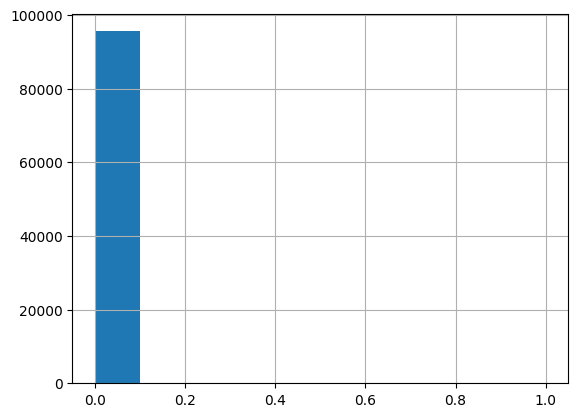

In [22]:
df['Tipo_Mensaje'].hist()
### Como se puede observar el dataset esta desbalanceado

### 2.2 Variable Objetivo Continua

Esta variable permite medir qué tan técnico o especializado es el contenido de cada mensaje mediante una escala gradual, en lugar de clasificarlo solo como “básico” o “avanzado”. Es útil para evaluar la calidad del contenido compartido, identificar mensajes con mayor aporte de conocimiento y entender el nivel general de experiencia presente en el chat. Desde una perspectiva práctica, ayuda a detectar a los usuarios más experimentados, promover contenido de mayor valor y comprender si la comunidad está funcionando como un espacio de aprendizaje y especialización.

### 2.2.1 Etiquetado de variable continua

In [23]:
ANCHOR_CASUAL = [
    "qué bonita planta",
    "me gusta mucho esa planta",
    "se ve bien chula",
    "está preciosa",
    "me encantan las plantas",
    "esa planta está rara",
    "nunca había visto una así",
    "yo quiero una",
    "dónde la compraste",
    "estoy imprimiendo una pieza en 3D",
    "mi impresora 3D falló otra vez",
    "ya terminé de imprimir el soporte",
    "estoy diseñando una pieza en fusion 360",
    "esa pieza quedó perfecta en PLA",
    "voy a soldar unos cables",
    "el ventilador ya no prende",
    "tengo que cambiar el relay",
    "el controlador dejó de funcionar",
    "buenos días",
    "jajaja",
    "no inventes",
    "qué onda",
    "gracias"
]

ANCHOR_EXPERT = [
    "Nepenthes villosa es una especie de alta montaña que requiere noches frías, alta humedad y excelente oxigenación radicular",
    "El peristoma de Nepenthes funciona como una superficie resbaladiza cuando está húmedo, facilitando la captura de presas",
    "Las Nepenthes de tierras altas presentan metabolismo adaptado a temperaturas nocturnas bajas",
    "El sustrato mineral con buen drenaje reduce el riesgo de pudrición radicular en Nepenthes",
    "Sarracenia presenta rizomas subterráneos y requiere un periodo de dormancia invernal para un crecimiento saludable",
    "Las Sarracenia obtienen nutrientes principalmente de insectos atrapados en sus ascidios",
    "La falta de dormancia puede debilitar progresivamente a las Sarracenia",
    "Drosera captura presas mediante mucílago producido por tricomas glandulares",
    "La digestión en Drosera ocurre mediante enzimas secretadas sobre la presa atrapada",
    "Pinguicula presenta hojas con glándulas pegajosas que permiten la captura de pequeños insectos",
    "Algunas especies de Pinguicula desarrollan hojas no carnívoras durante la estación seca",
    "Los híbridos interespecíficos de Nepenthes pueden mostrar dominancia fenotípica del peristoma",
    "La identificación taxonómica de Nepenthes se basa en características como el peristoma, la tapa y el indumento",
    "Existen complejos de especies en Nepenthes que dificultan su clasificación taxonómica",
    "El exceso de humedad estancada favorece infecciones fúngicas en plantas carnívoras",
    "La ventilación constante es clave para evitar patógenos en cultivos de Nepenthes",
    "El uso de agua con baja conductividad es fundamental para el cultivo de plantas carnívoras",
    "Muchas plantas carnívoras habitan suelos pobres en nutrientes, lo que explica su estrategia carnívora",
    "La captura de insectos permite a las plantas carnívoras suplementar nitrógeno y fósforo"
]

In [25]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
# Cargar modelo
embedder = SentenceTransformer("all-MiniLM-L6-v2")

#df = pd.read_csv("datos/variable_discreta.csv")

# Vectores promedio de referencia
expert_vec = embedder.encode(
    ANCHOR_EXPERT,
    normalize_embeddings=True
).mean(axis=0)

casual_vec = embedder.encode(
    ANCHOR_CASUAL,
    normalize_embeddings=True
).mean(axis=0)

# Procesar todos los mensajes en lote CON BARRA
mensajes = df["Mensaje"].tolist()

print(expert_vec.shape)
print(casual_vec.shape)

embeddings = embedder.encode(
    mensajes,
    batch_size=32,
    normalize_embeddings=True,   # importante
    show_progress_bar=True       # barra de progreso
)


print(embeddings.shape)




def score_especializacion_multi_anchor(embeddings, expert_vecs, casual_vecs, temperature=0.05):
    embeddings = np.atleast_2d(embeddings)
    expert_vecs = np.atleast_2d(expert_vecs)
    casual_vecs = np.atleast_2d(casual_vecs)

    sim_expert = (embeddings @ expert_vecs.T).max(axis=1)
    sim_casual = (embeddings @ casual_vecs.T).max(axis=1)

    exp_e = np.exp(sim_expert / temperature)
    exp_c = np.exp(sim_casual / temperature)

    prob_expert = exp_e / (exp_e + exp_c)
    confidence = np.maximum(sim_expert, sim_casual)

    return np.clip(prob_expert * confidence, 0, 1).round(3)




(384,)
(384,)


Batches:   0%|          | 0/2990 [00:00<?, ?it/s]

(95662, 384)


In [26]:
def contrastive_score(sim_expert, sim_casual, temperature=0.04):
    exp_e = np.exp(sim_expert / temperature)
    exp_c = np.exp(sim_casual / temperature)
    return exp_e / (exp_e + exp_c)

sim_expert = np.dot(embeddings, expert_vec)
sim_casual = np.dot(embeddings, casual_vec)

#scores = (sim_expert - sim_casual + 1) / 2

scores = contrastive_score(sim_expert, sim_casual)
df["especializacion"] = scores.round(3)
#df.to_csv("Datos_Etiquetados_3.csv", index=False)

### 3. Modelo Variable Objetivo Discreta

#### Preparación de los datos

In [ ]:
#### Hay que acomodar las celdas dentro de los subconjuntos preparacion de datos, train test split,Segmentación de sets, etc


#### Segmentación de sets

In [27]:
# Preparacion de Datos
X = df["Mensaje"]
y = df["Tipo_Mensaje"]


#### Train-test split

In [28]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

vectorizador = TfidfVectorizer(
    stop_words=spanish_stop_words,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    lowercase=True
)

X_train_tfidf = vectorizador.fit_transform(X_train)
X_test_tfidf = vectorizador.transform(X_test)

### Modelado

### Entrenamiento del Modelo

## 3. Regresion Logistica

### Tratanto el Desbalanceo

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

log_reg = LogisticRegression(max_iter=1000,solver='saga',  class_weight='balanced')


## Ajuste de Hiperparametros
param_dist = {
    'C': loguniform(1e-4, 1e2),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train_tfidf, y_train)

## Mejor Modelo
modelo = random_search.best_estimator_

print("Mejores hiperparámetros:")
print(random_search.best_params_)



Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Mejores hiperparámetros:
{'C': np.float64(36.30389268523312), 'l1_ratio': 0.75, 'penalty': 'l1'}


/home/eduardo-castillo/Documentos/diplomado/repositorio/librerias/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [30]:
# Evaluacion
from sklearn.metrics import classification_report, confusion_matrix

y_pred = modelo.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     28665
           1       0.14      0.82      0.24        34

    accuracy                           0.99     28699
   macro avg       0.57      0.91      0.62     28699
weighted avg       1.00      0.99      1.00     28699

[[28497   168]
 [    6    28]]


### Sin Tratar el Desbalanceo

In [31]:
# -----------------------------
# Sin tratar desbalance
# -----------------------------
log_reg = LogisticRegression(
    max_iter=1000,
    solver='saga'

)


param_dist = {
    'C': loguniform(1e-4, 1e2),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}


random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train_tfidf, y_train)


modelo_sin_desbalanceo = random_search.best_estimator_

print("Mejores hiperparámetros:")
print(random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Mejores hiperparámetros:
{'C': np.float64(58.48333713948906), 'l1_ratio': 1, 'penalty': 'l1'}


/home/eduardo-castillo/Documentos/diplomado/repositorio/librerias/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [32]:
# Evaluacion
from sklearn.metrics import classification_report, confusion_matrix

y_pred = modelo_sin_desbalanceo .predict(X_test_tfidf)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28665
           1       0.43      0.29      0.35        34

    accuracy                           1.00     28699
   macro avg       0.72      0.65      0.68     28699
weighted avg       1.00      1.00      1.00     28699

[[28652    13]
 [   24    10]]


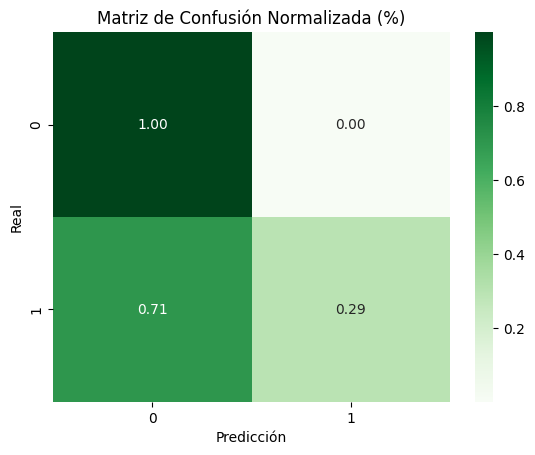

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión normalizada por fila
cm = confusion_matrix(y_test, y_pred, labels=modelo.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualización
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=modelo.classes_, yticklabels=modelo.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión Normalizada (%)")
plt.show()

### Palabras Asociadas a mensajes Tecnicos

In [ ]:
import numpy as np

feature_names = vectorizador.get_feature_names_out()
coeficientes = modelo.coef_[0]

top_palabras = sorted(
    zip(feature_names, coeficientes),
    key=lambda x: x[1],
    reverse=True
)[:100]

print("Palabras más asociadas a mensajes técnicos:")
for palabra, peso in top_palabras:
    print(palabra, round(peso, 3))

### Maquinas de Soporte Vectorial

In [34]:
from sklearn.svm import LinearSVC

svm = LinearSVC(
    class_weight='balanced',
    max_iter=2000
)

# Ajuste de Hiperparametro
param_dist = {
    'C': loguniform(1e-4, 1e2),
    'loss': ['hinge', 'squared_hinge']
}

random_search_svm = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    n_iter=40,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_svm.fit(X_train_tfidf, y_train)

# Mejor modelo
modelo_svm = random_search_svm.best_estimator_

print("Mejores hiperparámetros (SVM):")
print(random_search_svm.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/eduardo-castillo/Documentos/diplomado/repositorio/librerias/venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/eduardo-castillo/Documentos/diplomado/repositorio/librerias/venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/eduardo-castillo/Documentos/diplomado/repositorio/librerias/venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/eduardo-castillo/Documentos/diplomado/repositorio/librerias/venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/eduardo-castillo/Documentos/diplomado/repositorio/librerias/venv/lib/python3.1

Mejores hiperparámetros (SVM):
{'C': np.float64(49.35296209402104), 'loss': 'squared_hinge'}


/home/eduardo-castillo/Documentos/diplomado/repositorio/librerias/venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [35]:
### Evaluacion
y_pred = modelo.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     28665
           1       0.14      0.82      0.24        34

    accuracy                           0.99     28699
   macro avg       0.57      0.91      0.62     28699
weighted avg       1.00      0.99      1.00     28699

[[28497   168]
 [    6    28]]


###  Comparamos modelos

In [36]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, average_precision_score, confusion_matrix

modelos = {
    "SVM": modelo_svm,
    "Logistic Regression Balanceo": modelo,
    "Logistic Regresion Sin Balanceo":modelo_sin_desbalanceo 
}

for nombre, clf in modelos.items():

    pred = clf.predict(X_test_tfidf)
    
    # OJO: LinearSVC NO tiene predict_proba
    if hasattr(clf, "predict_proba"):
        proba = clf.predict_proba(X_test_tfidf)[:,1]
    else:
        # Usar decision_function como score continuo
        proba = clf.decision_function(X_test_tfidf)

    print(f"=== {nombre} ===")
    print("F1:", f1_score(y_test, pred))
    print("ROC-AUC:", roc_auc_score(y_test, proba))
    print("PR-AUC:", average_precision_score(y_test, proba))
    print("Matriz de confusión:\n", confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred))
    print("\n------------------\n")


=== SVM ===
F1: 0.37593984962406013
ROC-AUC: 0.9578703276182268
PR-AUC: 0.33996354447867577
Matriz de confusión:
 [[28591    74]
 [    9    25]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28665
           1       0.25      0.74      0.38        34

    accuracy                           1.00     28699
   macro avg       0.63      0.87      0.69     28699
weighted avg       1.00      1.00      1.00     28699


------------------

=== Logistic Regression Balanceo ===
F1: 0.24347826086956523
ROC-AUC: 0.9458337181026256
PR-AUC: 0.13032705202865777
Matriz de confusión:
 [[28497   168]
 [    6    28]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     28665
           1       0.14      0.82      0.24        34

    accuracy                           0.99     28699
   macro avg       0.57      0.91      0.62     28699
weighted avg       1.00      0.99      1.00     28699


---------

In [ ]:
""" Al tener nuestro dataset desbalanceado, el mejor modelo que se adapto a nuestro dataset, fue SVM ya que obtuvo el F1-score más alto (0.37) y el mayor PR-AUC (0.34),
 lo que indica un mejor compromiso entre precision y recall en la clase minoritaria. Además presentó un buen recall (0.74), evitando perder casos positivos, y un ROC-AUC elevado (0.95), 
 demostrando una adecuada separabilidad entre clases. Por ello, SVM maneja mejor el desbalance y ofrece el mejor desempeño general."""

#### Elección del mejor modelo para la variable discreta por (F1-score/ROC-AUC /Accuracy en test  hay que decidir)

### falta hacer la comparacion de los modelos para poder decir cual es mejor

### 2.2 Modelo Variable Objetivo Continua

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet

#### Preparación de los datos

In [ ]:
### leemos nuestro dataset etiquetado
df = pd.read_csv("Datos_Etiquetados_3.csv")

In [ ]:
df.drop(columns=["Tipo_Mensaje"], inplace=True)


#### Segmentación de sets

In [ ]:
tgt = "especializacion"
ls_pred = [x for x in df.columns if x not in [tgt]]

In [ ]:
df[[tgt]]

In [ ]:
X = df[ls_pred]
y = df[[tgt]]

#### Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Modelado

#### Reegresión lineal

In [ ]:
linreg = LinearRegression()

In [ ]:
linreg.fit(X, y)

In [ ]:
ls_res = cross_val_score(estimator = linreg, X=X, y=y, cv=4, n_jobs=-1, scoring="r2")

In [ ]:
np.mean(ls_res), np.std(ls_res)

In [ ]:
linreg.intercept_

In [ ]:
dc_scores = dict()

In [ ]:
str(linreg).split("(")[0]

In [ ]:
dc_scores.update({str(linreg).split("(")[0]: np.mean(ls_res)})

In [ ]:
dc_scores

#### Lasso

In [ ]:
lasso = Lasso()

In [ ]:
param_grid = {
    "alpha": [x for x in range(1, 100)] + [y/10 for y in range(10)],
    "tol": [0.00001, 0.0000001, 0.01],
    "selection": ['cyclic', 'random']
}

In [ ]:
np.prod(list(map(len, param_grid.values())))

In [ ]:
search = GridSearchCV(lasso, param_grid, cv=4, error_score=-1000, n_jobs=-1, scoring="r2", verbose=5)

In [ ]:
search.fit(X, y)

In [ ]:
print("Best score: " + str(search.best_score_))

In [ ]:
search.best_estimator_

In [ ]:
dc_scores[str(lasso).split("(")[0]] = {"model": search.best_estimator_, "score": search.best_score_}
dc_scores

#### Ridge

In [ ]:
ridge = Ridge()

In [ ]:
param_grid = {
    "alpha": [x for x in range(1, 100)] + [y/10 for y in range(10)],
    "tol": [0.00001, 0.0000001, 0.01],
    "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

In [ ]:
search = RandomizedSearchCV(ridge, param_grid, cv=4, error_score=-1_000, n_jobs=-1, scoring="r2", verbose=1, n_iter=100)
search.fit(X_train, y_train)

In [ ]:
print("Best score: " + str(search.best_score_))

In [ ]:
dc_scores[str(ridge).split("(")[0]] = {"model": search.best_estimator_, "score": search.best_score_}
dc_scores

#### Elasticnet

In [ ]:
elnet = ElasticNet()

In [ ]:
param_grid = {
    "alpha": [x for x in range(1, 100)] + [y/10 for y in range(10)],
    "l1_ratio": [x/1_00 for x in range(1, 100)] + [y/10 for y in range(10)],
    "selection": ["cyclic", "random"]
}

In [ ]:
search = GridSearchCV(elnet, param_grid, cv=4, error_score=-1_000, n_jobs=-1, scoring="r2", verbose=1)

In [ ]:
search.fit(X_train, y_train)

In [ ]:
print("Best score: " + str(search.best_score_))

#### Elección del mejor modelo para la variable continua por Error (RMSE)

In [ ]:
dc_scores[str(elnet).split("(")[0]] = {"model": search.best_estimator_, "score": search.best_score_}
dc_scores
